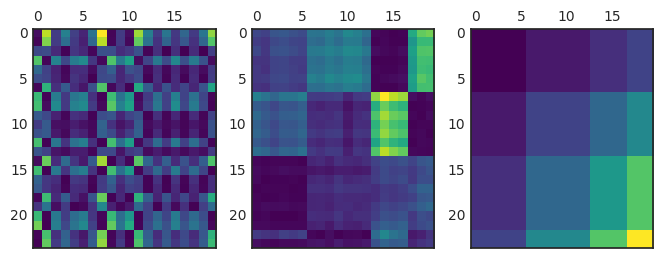

In [19]:
import itertools
import numpy as np
import sklearn
from sklearn.cluster.bicluster import SpectralBiclustering
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('white')
plt.rcParams['image.cmap'] = 'viridis'
%matplotlib inline

properties = ['salt', 'roast', 'grease', 'crunch']

clusters = {
    'more-is-more': [1., 1., 1., .1],
    'natural': [0., 0.1, 0.1, 0.4],
    'ok-but-too-salt': [0.8, 0.5, 0.5, .5],
    'dry-and-soft': [0.5, 0.5, 0.1, 0.2]
}

M = 24
N = 20

def nut_generator(clusters):
    cluster_names = list(clusters.keys())
    while True:
        name = np.random.choice(cluster_names)
        yield (name, clusters[name] + 0.3 * np.random.random(len(properties)))

ng = nut_generator(clusters)
people_names_data = [next(ng) for i in range(M)]
people_raw = np.stack(list(zip(*people_names_data))[1])
nuts_names_data = [next(ng) for j in range(N)]
nuts_raw = np.stack(list(zip(*nuts_names_data))[1])

nuts = pd.DataFrame(nuts_raw, columns=properties, index=['N{}'.format(i+1) for i in range(len(nuts_raw))])

def make_scores(people, nuts):
    scores = np.zeros((M, N))
    for (i, p), (j, n) in itertools.product(enumerate(people), enumerate(nuts)):
        closeness = sum((p - n) ** 2)
        scores[i, j] = closeness
    return scores

def fit_model(scores, n_clusters):
    model = SpectralBiclustering(
        n_clusters=n_clusters, method='log', random_state=0)
    model.fit(scores)
    return model

def sort_scores(scores, model):
    sorted_scores = scores[np.argsort(model.row_labels_)]
    sorted_scores = sorted_scores[:, np.argsort(model.column_labels_)]
    return sorted_scores
    
def simulate_and_plot(scores, n_clusters):
    model = fit_model(scores, n_clusters)
    sorted_scores = sort_scores(scores, model)

    fig, ax = plt.subplots(1, 3, figsize=(8, 10))
    ax[0].matshow(scores)
    ax[1].matshow(sorted_scores)
    
    ax[2].matshow(np.outer(np.sort(model.row_labels_) + 1,
                     np.sort(model.column_labels_) + 1))

simulate_and_plot(make_scores(people_raw, nuts_raw), (4, 4))

In [20]:
def reorder_array_like(arr, labels):
    d = list(zip(arr, labels))
    d.sort(key=lambda pair: pair[1])
    return list(zip(*d))[0]

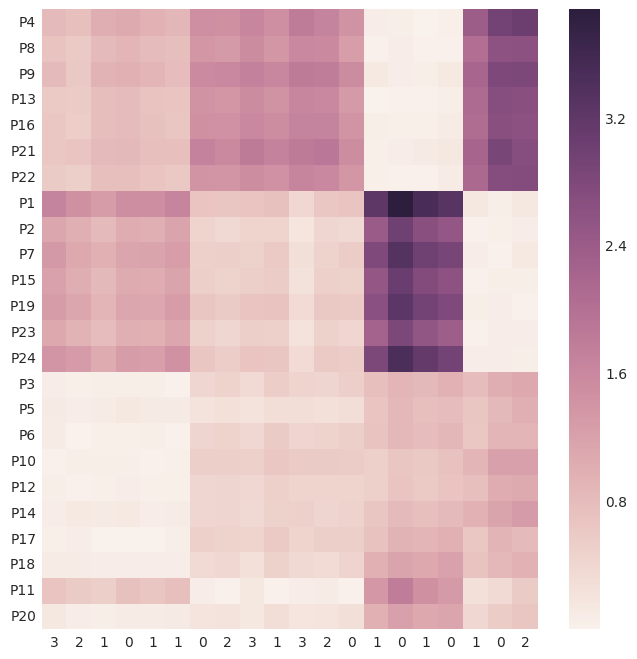

In [21]:
m = fit_model(make_scores(people_raw, nuts_raw), (4, 4))
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.matrix.heatmap(
    pd.DataFrame(
        sort_scores(make_scores(people_raw, nuts_raw), m),
        columns=m.column_labels_,
        index=reorder_array_like(pd.Series(['P{}'.format(i+1) for i in range(M)]), m.row_labels_)),
    ax=ax)
plt.setp(ax.yaxis.get_ticklabels(), rotation=0);

In [22]:
pd.DataFrame({
        'true': list(zip(*people_names_data))[0],
        'guess': m.row_labels_
        })

,guess,true
0,1,natural
1,1,natural
2,2,ok-but-too-salt
3,0,more-is-more
4,2,ok-but-too-salt
5,2,ok-but-too-salt
6,1,natural
7,0,more-is-more
8,0,more-is-more
9,2,ok-but-too-salt


In [27]:
nuts['category'] = m.column_labels_

In [28]:
def plot_pairs(data, max_cols=3, color=None):
    data = pd.DataFrame(data)
    colnames = data.columns
    rows = int(np.ceil(len(colnames) / max_cols))
    cols = min(max_cols, len(colnames))
    pairs = list(itertools.combinations(colnames, 2))
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    for (propa, propb), ax in zip(pairs, axs.flat):
        ax.scatter(data[propa], data[propb], marker='.', color=color)
        ax.set_xlabel(propa)
        ax.set_ylabel(propb)
        fig.tight_layout()

In [29]:
def cycler():
    while True:
        yield 'r'
        yield 'b'
        yield 'k'

In [30]:
colors = ['r', 'b', 'k', 'm']

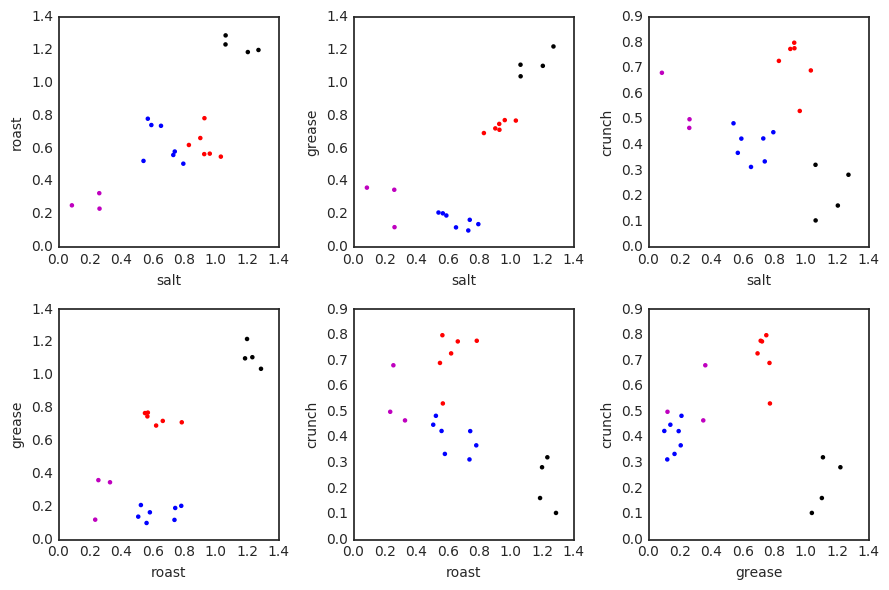

In [31]:
c = cycler()
plot_pairs(nuts[properties], color=[colors[v] for v in nuts['category']])

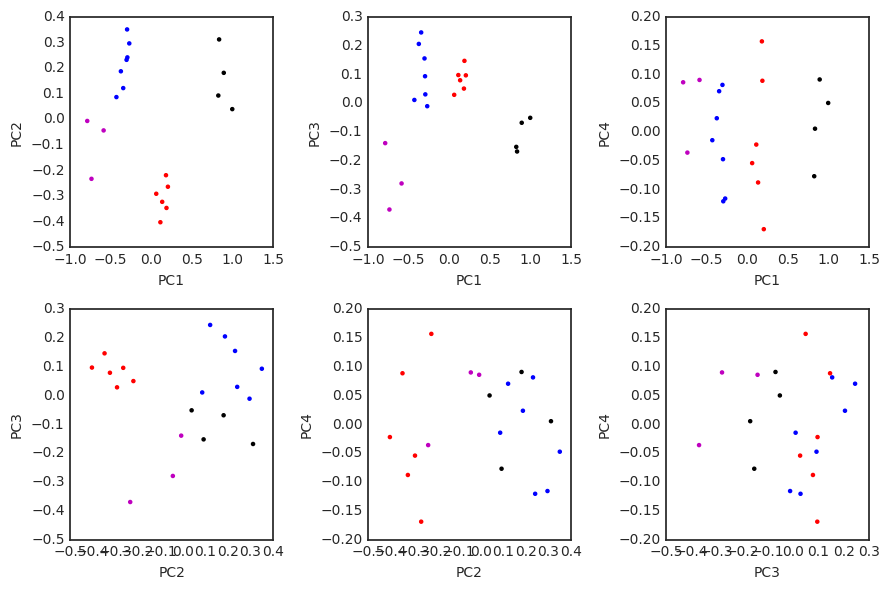

In [32]:
pca = sklearn.decomposition.PCA()
d = pd.DataFrame(pca.fit_transform(nuts[properties]), columns=['PC{}'.format(i + 1) for i in range(len(properties))])
plot_pairs(d, color=[colors[v] for v in nuts['category']])

In [38]:
PROPERTY_NAMES = ['Salt', 'Knaprig', 'Rostad', 'Flottig']

In [39]:
def load_data(path):
    d = pd.read_csv(path)
    
    d = d.rename(
        columns={ ''
            'Din TBF': 'TBF',
            'Vilken jordnöt?': 'Nöt',
            'Betygsätt totalupplevelsen': 'Betyg'
        })

    nuts = ['{}{:02}'.format(v[0], int(v[1:])) for v in d['Nöt']]
    d['Nöt'] = nuts
    
    def get_latest(d):
        return d.sort_values('Timestamp', ascending=False).iloc[0]

    
    return d.groupby(['TBF', 'Nöt']).apply(get_latest).reset_index(drop=True)

In [40]:
d = load_data('Untitled form.csv')

In [41]:
properties = d.groupby('Nöt')[PROPERTY_NAMES].mean()
properties

,Salt,Knaprig,Rostad,Flottig
Nöt,,,,
J02,3,6,3,6
J06,6,4,5,3
J07,1,1,1,1
J08,5,2,5,3
J11,3,5,3,6
J12,4,5,5,7
J16,6,3,5,3
J20,4,2,5,3


In [42]:
scores = d.set_index(['TBF', 'Nöt'])['Betyg'].unstack()

In [43]:
scores

Nöt,J02,J06,J07,J08,J11,J12,J16,J20
TBF,,,,,,,,
ATG,NaN,NaN,1.0,NaN,4.0,NaN,NaN,NaN
PPA,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
PSI,1.0,NaN,NaN,7.0,NaN,6.0,5.0,5.0


In [44]:
r = scores.loc['ATG']
r.where(r.notnull(), scores.mean())

Nöt
J02    1.0
J06    5.0
J07    1.0
J08    7.0
J11    4.0
J12    6.0
J16    5.0
J20    5.0
Name: ATG, dtype: float64

In [45]:
scores_filled = scores.apply(lambda row: row.where(row.notnull(), scores.mean()), axis=1)

In [46]:
fit_model(scores_filled, (2, 2))

SpectralBiclustering(init='k-means++', method='log', mini_batch=False,
           n_best=3, n_clusters=(2, 2), n_components=6, n_init=10,
           n_jobs=1, n_svd_vecs=None, random_state=0,
           svd_method='randomized')